In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow import keras
from tensorflow.keras.callbacks import Callback

2024-06-21 15:15:27.603553: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 15:15:28.319315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the data
df = pd.read_csv('./steel_data/Steel_industry_data.csv')
df.head(1)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load


In [3]:
#Rename the columns for simplicity
df = df.rename(columns={'CO2(tCO2)': 'tco2',
                        'Lagging_Current_Reactive.Power_kVarh': 'lagging_kvarh',
                        'Leading_Current_Reactive_Power_kVarh': 'leading_kvarh',
                        'Lagging_Current_Power_Factor': 'lagging_pf',
                        'Leading_Current_Power_Factor': 'leading_pf'})

df.columns = df.columns.str.lower()

In [4]:
# Check for nulls
print("NA values: " , df.isna().sum().sum())
print("Null values: ", df.isnull().sum().sum())

NA values:  0
Null values:  0


In [5]:
# Create new column and drop the old one
df["kgco2"] = df.tco2 * 1000
df.drop('tco2', inplace=True, axis=1)

df.head(1)

,date,usage_kwh,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,nsm,weekstatus,day_of_week,load_type,kgco2
0,01/01/2018 00:15,3.17,2.95,0.0,73.21,100.0,900,Weekday,Monday,Light_Load,0.0


In [6]:
unique_values = df['weekstatus'].unique()
unique_values

array(['Weekday', 'Weekend'], dtype=object)

In [7]:


def preprocessing_column(dataframe, old_name, new_name, function):
    dataframe[new_name] = df[old_name].apply(function)
    dataframe.drop(old_name, axis = 1, inplace=True)

def encoding_day_of_week(value):
    mapping = {
          'Monday': 2,
          'Tuesday': 3,
          'Wednesday': 4,
          'Thursday': 5,
          'Friday': 6,
          'Saturday': 7,
          'Sunday': 1
      }
    return mapping.get(value)
def encoding_load_type(value):
    mapping = {
          'Light_Load': 0,
          'Medium_Load': 1,
          'Maximum_Load': 2,
      }
    return mapping.get(value)
def encoding_weekstatus(value):
    mapping = {
          'Weekday': 0,
          'Weekend': 1,
      }
    return mapping.get(value)
def encoding_date(value):
    date_obj = datetime.strptime(value, '%d/%m/%Y %H:%M')
    hour = date_obj.hour
    minute = date_obj.minute

    encoded_value = (hour * 60 + minute) // 15
    return encoded_value


preprocessing_column(df,'day_of_week', 'new_day_of_week', encoding_day_of_week)
preprocessing_column(df,'load_type', 'new_load_type', encoding_load_type)
preprocessing_column(df,'date', 'new_date', encoding_date)
preprocessing_column(df,'weekstatus', 'new_weekstatus', encoding_weekstatus)


df.head(1)

,usage_kwh,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,nsm,kgco2,new_day_of_week,new_load_type,new_date,new_weekstatus
0,3.17,2.95,0.0,73.21,100.0,900,0.0,2,0,1,0


In [8]:
Y = df['usage_kwh'].to_numpy()
X = df.drop('usage_kwh', axis =1).to_numpy()

X_3D = X.reshape((X.shape[0], X.shape[1], 1))
Y_3D = Y.reshape((Y.shape[0], 1))

X_3D.shape, Y_3D.shape

((35040, 10, 1), (35040, 1))

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X_3D, Y_3D, test_size=0.2, random_state= 128)

In [10]:
class MetricsHistory(Callback):
    def __init__(self, x_train, y_train, tittle_graph, path_tosaveImg):
        super(MetricsHistory, self).__init__()
        self.metrics_values = {
            'mse': [],
            'rmse': [],
            'r_squared': [],
            'loss': []
        }
        self.epoch_values = []
        self.x_train = x_train
        self.y_train = y_train
        self.tittle_graph = tittle_graph
        self.path_tosaveImg = path_tosaveImg

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.y_train
        y_pred = self.model.predict(self.x_train)

        mse, rmse, r_squared = calculate_metrics(y_true, y_pred)
        loss = logs['loss']

        self.metrics_values['mse'].append(mse)
        self.metrics_values['rmse'].append(rmse)
        self.metrics_values['r_squared'].append(r_squared)
        self.metrics_values['loss'].append(loss)
        self.epoch_values.append(epoch + 1)

    def on_train_end(self, logs=None):
        plt.figure(1)
        plt.plot(self.epoch_values, self.metrics_values['mse'], 'b-', label='MSE')
        plt.plot(self.epoch_values, self.metrics_values['rmse'], 'r-', label='RMSE')
        plt.plot(self.epoch_values, self.metrics_values['r_squared'], 'g-', label='R^2')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.title(self.tittle_graph[0])
        plt.legend()
        plt.savefig( self.path_tosaveImg[0] )

        plt.figure(2)
        plt.plot(self.epoch_values, self.metrics_values['loss'], 'y-', label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(self.tittle_graph[1])
        plt.legend()
        plt.savefig( self.path_tosaveImg[1])

        plt.show()

def calculate_metrics(y_true, y_pred):
    n = len(y_true)
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    ss_total = np.sum((y_true - np.mean(y_true))**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)
    return mse, rmse, r_squared

Epoch 1/500


2024-06-21 15:15:29.608442: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/choconao/Documents/Programming/Python/ml-hometask/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1538.0704 - val_loss: 1192.0289
Epoch 2/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1101.6183 - val_loss: 904.1001
Epoch 3/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 837.0612 - val_loss: 713.5522
Epoch 4/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 682.0392 - val_loss: 571.3859
Epoch 5/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 538.6223 - val_loss: 464.9808
Epoch 6/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 437.2514 - val_loss: 387.3114
Epoch 7/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 375.8067 - val_loss: 332.0155
Epoch 8/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step
110/110 ━━━━━━━

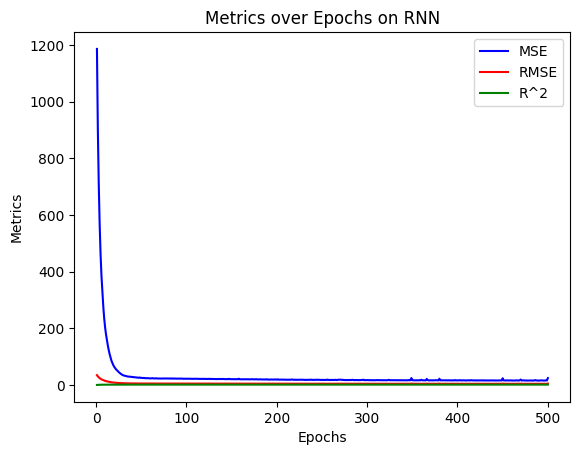

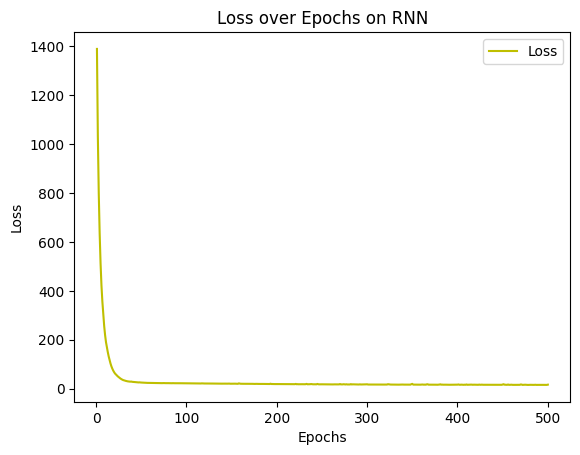

In [11]:
# Train RNN model
model_RNN = keras.Sequential()
model_RNN.add(keras.layers.SimpleRNN(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_RNN.add(keras.layers.Dense(units=1))
model_RNN.compile(optimizer='adam', loss='mse')
metrics_history_callback = MetricsHistory(X_train, Y_train,['Metrics over Epochs on RNN', 'Loss over Epochs on RNN'], ['./output/rnn_gru_lstm/RNN_metrics.png', './output/rnn_gru_lstm/RNN_loss.png'])
model_RNN.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs=500, batch_size=256, callbacks=[metrics_history_callback])

In [12]:
# Save RNN model
model_RNN.save('./output/rnn_gru_lstm/RNN_model.keras')

In [13]:
# Predict values
Y_pred = model_RNN.predict(X_test)
mse, rmse, r_squared = calculate_metrics(Y_test, Y_pred)
print("Metric for RNN")
print("MSE = "+str(mse))
print("RMSE = "+str(rmse))
print("R^2 = "+str(r_squared))

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Metric for RNN
MSE = 25.33508479506416
RMSE = 5.033396943920096
R^2 = 0.9774590103877767


Epoch 1/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 1680.9872 - val_loss: 1207.4296
Epoch 2/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1106.7156 - val_loss: 878.4639
Epoch 3/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 834.5064 - val_loss: 675.1600
Epoch 4/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 636.2855 - val_loss: 532.9102
Epoch 5/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 502.1260 - val_loss: 429.3193
Epoch 6/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 395.6198 - val_loss: 352.6417
Epoch 7/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 327.1428 - val_loss: 292.7789
Epoch 8/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
110/110 ━━━

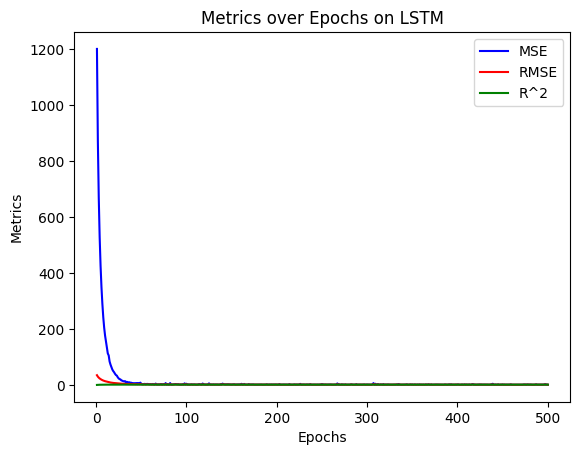

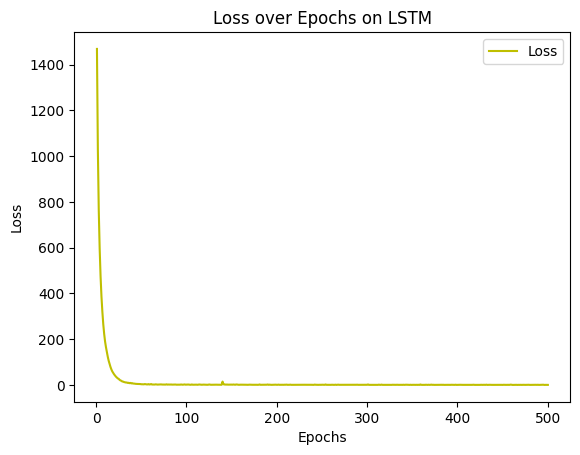

In [14]:
# Train LSTM model
model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_LSTM.add(keras.layers.Dense(units=1))
model_LSTM.compile(optimizer='adam', loss='mse')
metrics_history_callback = MetricsHistory(X_train, Y_train,['Metrics over Epochs on LSTM', 'Loss over Epochs on LSTM'], ['./output/rnn_gru_lstm/LSTM_metrics.png', './output/rnn_gru_lstm/LSTM_loss.png'])
model_LSTM.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs=500, batch_size=256, callbacks=[metrics_history_callback])

In [15]:
# Save LSTM model
model_LSTM.save('./output/rnn_gru_lstm/LSTM_model.keras')

In [16]:
Y_pred = model_LSTM.predict(X_test)
mse, rmse, r_squared = calculate_metrics(Y_test, Y_pred)
print("Metric for LSTM")
print("MSE = "+str(mse))
print("RMSE = "+str(rmse))
print("R^2 = "+str(r_squared))

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Metric for LSTM
MSE = 0.6314509593555951
RMSE = 0.7946388861335664
R^2 = 0.9994381889924349


Epoch 1/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1614.6135 - val_loss: 1235.2368
Epoch 2/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1195.6401 - val_loss: 929.8922
Epoch 3/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 864.6531 - val_loss: 713.6743
Epoch 4/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 661.5112 - val_loss: 566.7118
Epoch 5/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 531.3986 - val_loss: 464.9082
Epoch 6/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 450.5229 - val_loss: 393.9371
Epoch 7/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 359.7372 - val_loss: 316.0125
Epoch 8/500
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110

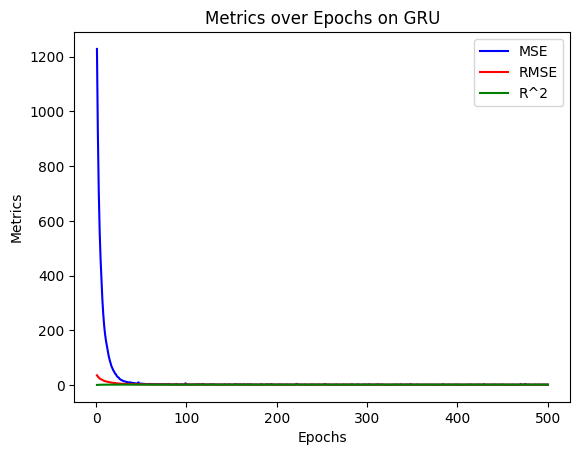

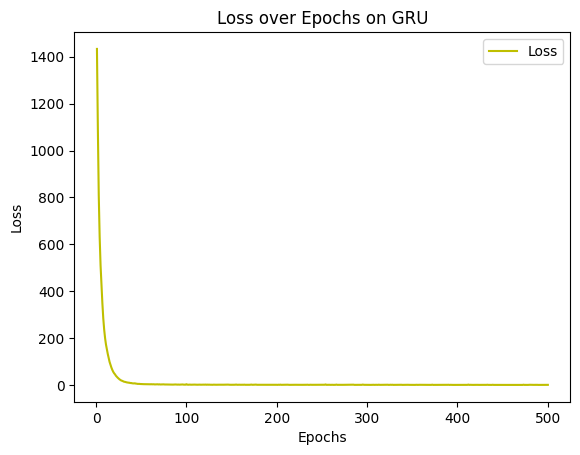

In [17]:
# Train GRU model
model_GRU = keras.Sequential()
model_GRU.add(keras.layers.GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_GRU.add(keras.layers.Dense(units=1))
model_GRU.compile(optimizer='adam', loss='mse')
metrics_history_callback = MetricsHistory(X_train, Y_train,['Metrics over Epochs on GRU', 'Loss over Epochs on GRU'], ['./output/rnn_gru_lstm/GRU_metrics.png', './output/rnn_gru_lstm/GRU_loss.png'])
model_GRU.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs=500, batch_size=256, callbacks=[metrics_history_callback])

In [18]:
# Save GRU model
model_GRU.save('./output/rnn_gru_lstm/GRU_model.keras')

In [19]:
Y_pred = model_GRU.predict(X_test)
mse, rmse, r_squared = calculate_metrics(Y_test, Y_pred)
print("Metric for GRU")
print("MSE = "+str(mse))
print("RMSE = "+str(rmse))
print("R^2 = "+str(r_squared))

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
Metric for GRU
MSE = 0.8473547549132918
RMSE = 0.9205187422933288
R^2 = 0.9992460962778349
